## Test ML models
### h2o.ai
Transform netCDF serialized files to h2o dataframes via xarray and pandas.

In [1]:
from dask.distributed import Client
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:53252 Dashboard: http://127.0.0.1:48091/status,Cluster Workers: 6 Cores: 24 Memory: 33.55 GB


In [7]:
client.close()

Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 179, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 200, in read
    convert_stream_closed_error(self, e)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/d

In [2]:
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack

In [2]:

data_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/'
out_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'

t = eotempstack.S1TempStack(data_dir, out_dir, 'ASCENDING')


S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/


In [3]:
t.getTempData()

{'VV': [datetime.date(2018, 4, 8),
  datetime.date(2015, 11, 27),
  datetime.date(2016, 2, 7),
  datetime.date(2018, 4, 20),
  datetime.date(2015, 12, 21),
  datetime.date(2016, 1, 14)]}

In [4]:
t.out_directory+t.prod_type+'_'+t.orbit+'_'#+month+'.nc'

'/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/S1_ASCENDING_'

In [3]:
t.createXDataset()

In [9]:
from datetime import datetime as dt
from calendar import monthrange
time_ranges = list([(dt.strptime('01'+x.strftime('%m%Y'), '%d%m%Y').date(),
                            dt.strptime(str(monthrange(x.year, x.month)[1])+x.strftime('%m%Y'), '%d%m%Y').date()) for x in next(iter(t.getTempData().values()))])

In [11]:
list(time_ranges)

[(datetime.date(2015, 11, 1), datetime.date(2015, 11, 30)),
 (datetime.date(2015, 12, 1), datetime.date(2015, 12, 31)),
 (datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)),
 (datetime.date(2016, 2, 1), datetime.date(2016, 2, 29))]

In [15]:
t.getTempData()#.values()

{'VV_ASM': [],
 'VV_Contrast': [],
 'VV_Dissimilarity': [],
 'VV_Energy': [],
 'VV_Entropy': [],
 'VV_GLCMCorrelation': [],
 'VV_GLCMMean': [],
 'VV_GLCMVariance': [],
 'VV_Homogeneity': [],
 'VH_ASM': [],
 'VH_Contrast': [],
 'VH_Dissimilarity': [],
 'VH_Energy': [],
 'VH_Entropy': [],
 'VH_GLCMCorrelation': [],
 'VH_GLCMMean': [],
 'VH_GLCMVariance': [],
 'VH_Homogeneity': []}

In [3]:
saldana = regionstack.regionStack('Saldana_training_2015')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7fc4f538f488>
Reading 8 S1 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7fc4f537ee88>
Reading 6 S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 4 GLCM_S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 3 GLCM_S1 stack files
S2 object initialized from /mnt/workspace_cluster_6/TRANSVER

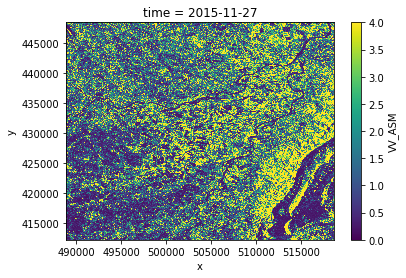

In [6]:
saldana.S1_ASCENDING_GLCM.isel(time=0).VV_ASM.plot()

In [9]:
saldana.S2

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    LSWI     (time, y, x) 

In [6]:
saldana.calcTempVariation('S2', ['NDVI','LSWI'])#,'red', 'green','blue','nir','swir1','swir2'])

Processing band NDVI for date 2015-12-21T00:00:00.000000000
Processing band NDVI for date 2015-12-31T00:00:00.000000000
Processing band NDVI for date 2016-01-10T00:00:00.000000000
Processing band NDVI for date 2016-01-20T00:00:00.000000000
Processing band NDVI for date 2016-01-30T00:00:00.000000000
Processing band NDVI for date 2016-02-09T00:00:00.000000000
Processing band NDVI for date 2016-02-19T00:00:00.000000000
Processing band LSWI for date 2015-12-21T00:00:00.000000000
Processing band LSWI for date 2015-12-31T00:00:00.000000000
Processing band LSWI for date 2016-01-10T00:00:00.000000000
Processing band LSWI for date 2016-01-20T00:00:00.000000000
Processing band LSWI for date 2016-01-30T00:00:00.000000000
Processing band LSWI for date 2016-02-09T00:00:00.000000000
Processing band LSWI for date 2016-02-19T00:00:00.000000000


In [9]:
#saldana.calcTempVariation('S1_ASCENDING', ['VV'])
saldana.calcTempVariation('S1_DESCENDING', ['VV'])
#saldana.S1_ASCENDING #[['NDVI_c','LSWI_c']]

Processing band VV for date 2015-12-28T00:00:00.000000000
Processing band VV for date 2016-01-21T00:00:00.000000000
Processing band VV for date 2016-02-14T00:00:00.000000000


In [17]:
ratio = saldana.S1_DESCENDING.VV / saldana.S1_DESCENDING.VH

In [4]:
shp_file = '/home/azalazar/data/saldana.shp'

saldana.regionTrainingClasses(shp_file, testset=0.3)

Adding dataset with classes as class_ds attribute of regionStack


In [5]:
data_dict = dict([('S1_DESCENDING',['VV','VV_c']),
                  ('S1_ASCENDING',['VV','VV_c']),
                  ('S1_ASCENDING_GLCM',['VV_ASM','VV_Contrast','VV_Dissimilarity',
                                        'VV_Energy','VV_Entropy','VV_GLCMCorrelation',
                                        'VV_GLCMMean','VV_GLCMVariance','VV_Homogeneity']),
                  ('S1_DESCENDING_GLCM',['VV_ASM','VV_Contrast','VV_Dissimilarity',
                                         'VV_Energy','VV_Entropy','VV_GLCMCorrelation',
                                         'VV_GLCMMean','VV_GLCMVariance','VV_Homogeneity'])])
data_dict

{'S1_DESCENDING': ['VV', 'VV_c'],
 'S1_ASCENDING': ['VV', 'VV_c'],
 'S1_ASCENDING_GLCM': ['VV_ASM',
  'VV_Contrast',
  'VV_Dissimilarity',
  'VV_Energy',
  'VV_Entropy',
  'VV_GLCMCorrelation',
  'VV_GLCMMean',
  'VV_GLCMVariance',
  'VV_Homogeneity'],
 'S1_DESCENDING_GLCM': ['VV_ASM',
  'VV_Contrast',
  'VV_Dissimilarity',
  'VV_Energy',
  'VV_Entropy',
  'VV_GLCMCorrelation',
  'VV_GLCMMean',
  'VV_GLCMVariance',
  'VV_Homogeneity']}

In [6]:
saldana.buildTrainingDataFrame(data_dict, ['test'])

Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test0/ . 1 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test1/ . 2 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test2/ . 3 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test3/ . 4 of 6...
Writing test parquet dataset to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/parquet/test4/ . 5 of 6...
Writing test parquet dataset to /mnt/workspac

In [12]:
import numpy as np
for index, date in np.ndenumerate(saldana.S2.time.values):
    print(index[0])

0
1
2
3
4
5
6
7


In [18]:
import numpy as np
test = np.array([1,2,3,4,5,5])
np.unique(test)

array([1, 2, 3, 4, 5])

In [12]:
import numpy as np
a = np.array([], dtype=np.datetime64)
a = np.append(a, saldana.S2.time.values)
#print(a)
#for num in range(10):
#    print(num)
#    a = np.append(a, num)
print(a)

['2015-12-11T00:00:00.000000000' '2015-12-21T00:00:00.000000000'
 '2015-12-31T00:00:00.000000000' '2016-01-10T00:00:00.000000000'
 '2016-01-20T00:00:00.000000000' '2016-01-30T00:00:00.000000000'
 '2016-02-09T00:00:00.000000000' '2016-02-19T00:00:00.000000000']


In [11]:
saldana.S1_DESCENDING_GLCM = saldana.S1_DESCENCDING_GLCM

In [12]:
saldana.train#.to_netcdf(saldana.data_directory+'train.nc')#, chunks={'time':1})

AttributeError: 'regionStack' object has no attribute 'train'

In [21]:
client

Client Scheduler: tcp://127.0.0.1:41298 Dashboard: http://127.0.0.1:55865/status,Cluster Workers: 4 Cores: 24 Memory: 33.55 GB


In [27]:
t_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/'
train_data = xr.open_mfdataset(t_dir+'train.nc', chunks={'time':1, 'x':1000,'y':1220})
train_data

<xarray.Dataset>
Dimensions:   (time: 4, x: 2981, y: 3635)
Coordinates:
  * y         (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time      (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 2016-01-10
    mask      (time, x, y) bool dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
Data variables:
    NDVI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    LSWI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_ASC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VH_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    train     (time, x, y) float64 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
   

In [190]:
saldana.S1_DESCENDING.time.values

array(['2015-12-04T00:00:00.000000000', '2015-12-28T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-02-14T00:00:00.000000000'],
      dtype='datetime64[ns]')

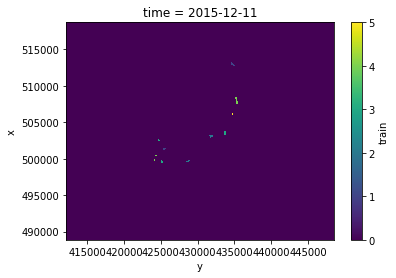

In [18]:
train_data.train.isel(time=0).plot()

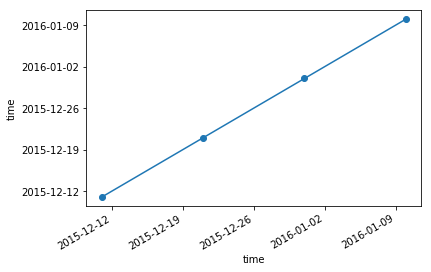

In [37]:
saldana.train.time.plot(marker='o')

### Machine learning with h2o.ai

In [11]:
import h2o

In [14]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda3/envs/models3/h2o_jar/h2o.jar
  Ice root: /tmp/tmp960was14
  JVM stdout: /tmp/tmp960was14/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmp960was14/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,3 months and 12 days !!!
H2O cluster name:,H2O_from_python_azalazar_287l3b
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


In [28]:
# Select only data from a date and transform to pandas dataframe
data_pd = train_data.to_dask_dataframe()

In [29]:
data_pd

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
data_train = data_pd[data_pd['train']>0]

In [30]:
data_test = data_pd[data_pd['test']>0]

In [31]:
data_test

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
# Remove multi-index, as it is not preserved in h20
data_pd#_v2.reset_index(inplace=True)

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [32]:
# Inspect dataframe
# Select only data from a date and transform to pandas dataframe
from dask.diagnostics import ProgressBar
from dask.dataframe import to_parquet
with ProgressBar():
    to_parquet(data_test, saldana.data_directory+'test_parquet/')#train_temp-*.parquet')
    #data_pd.to_csv(, chunksize=10835935)

In [143]:
# Load data to h2o frame
import os
import re

def read_parquet_data(datadir, tag):
    
    files = list(filter(re.compile(r'^'+tag+'.*').search, os.listdir(datadir)))
    
    data = [h2o.import_file(datadir+x) for x in files]
    
    data = [x.asnumeric() for x in data]
    
    return mergedataset(data)

def mergedataset (dslist):
    if len(dslist)==1:
        return dslist[0]
    else:
        return dslist[0].rbind(mergedataset(dslist[1:]))


In [140]:
data = read_parquet_data(saldana.data_directory+'parquet/', 'train')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [142]:
data.shape

(64066, 17)

In [80]:
data['train'] = data['train'].asfactor()
#erg['test'] = erg['test'].asfactor() #encode the class response as a factor
#after encoding, this shows the 5 factor levels, in this dataset '2' is missing!!!

In [81]:
data['train'].levels()

[['1', '2', '3', '4', '5']]

In [40]:
data['test'].levels()

[['0']]

In [82]:
# To train and test the model using only this data, split data
train, valid = erg.split_frame(ratios=[0.5], seed=1)
# train = splits[0]
# valid = splits[1]
# test = splits[2]

In [83]:
# Show number of observations from each dataset
print(train.nrow)
print(valid.nrow)
#print test.nrow

31998
32068


In [84]:
# Define response variables and predictors
y = 'train'
x = list(data.columns)

In [85]:
x.remove(y)  #remove the response
x.remove('time')
x.remove('x')
x.remove('y')
x.remove('test')
#x.remove('mask')
x.remove('__index_level_0__')
#x.remove('qa_cloud') #remove cloud mask

In [86]:
# Show predictors
x

['VV',
 'VV_c',
 'VV_ASM',
 'VV_Contrast',
 'VV_Dissimilarity',
 'VV_Energy',
 'VV_Entropy',
 'VV_GLCMCorrelation',
 'VV_GLCMMean',
 'VV_GLCMVariance',
 'VV_Homogeneity']

In [72]:
# test random forest
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [73]:
# Initialize model
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [74]:
# Train model
rf_v1.train(x, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [75]:
# Print model details
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_covType_v1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.4222375399443899
RMSE: 0.6497980762855411
LogLoss: 1.2995743929151637
Mean Per-Class Error: 0.5310507695025152
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
3200.0,341.0,899.0,1050.0,740.0,0.4863563,"3,030 / 6,230"
355.0,1140.0,1318.0,1102.0,240.0,0.7256318,"3,015 / 4,155"
523.0,636.0,4766.0,2274.0,826.0,0.4719114,"4,259 / 9,025"
454.0,446.0,1797.0,4368.0,734.0,0.4399282,"3,431 / 7,799"
794.0,118.0,865.0,768.0,2244.0,0.5314262,"2,545 / 4,789"
5326.0,2681.0,9645.0,9562.0,4784.0,0.5087818,"16,280 / 31,998"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.4912182
2,0.747953
3,0.9066192
4,0.9796237
5,1.0



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.4176550900109851
RMSE: 0.6462624002763777
LogLoss: 1.1538617594635612
Mean Per-Class Error: 0.5190336635516971
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
3294.0,293.0,873.0,1028.0,720.0,0.4693943,"2,914 / 6,208"
312.0,1166.0,1247.0,1142.0,234.0,0.7156791,"2,935 / 4,101"
456.0,619.0,4930.0,2342.0,744.0,0.4577054,"4,161 / 9,091"
404.0,437.0,1771.0,4453.0,715.0,0.4276350,"3,327 / 7,780"
835.0,122.0,825.0,783.0,2323.0,0.5247545,"2,565 / 4,888"
5301.0,2637.0,9646.0,9748.0,4736.0,0.4958837,"15,902 / 32,068"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.5041162
2,0.7612573
3,0.9141511
4,0.9846263
5,0.9999999


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-06-18 14:50:18,0.074 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-18 14:50:22,4.268 sec,1.0,0.7206666,11.4626082,0.5891148,0.7228266,11.6525961,0.5951416
,2018-06-18 14:50:24,5.691 sec,2.0,0.7152213,10.5160893,0.5856704,0.6790858,6.6014714,0.5624922
,2018-06-18 14:50:24,6.231 sec,3.0,0.7020882,9.0753240,0.5761744,0.6634432,4.1472407,0.5445927
,2018-06-18 14:50:25,6.863 sec,4.0,0.6957959,8.1606009,0.5704661,0.6583166,3.1718167,0.5343333
---,---,---,---,---,---,---,---,---,---
,2018-06-18 14:51:02,44.365 sec,49.0,0.6497861,1.3220112,0.5110319,0.6461571,1.1568597,0.4962268
,2018-06-18 14:51:03,45.317 sec,50.0,0.6496018,1.3134047,0.5105007,0.6460940,1.1554496,0.4955407
,2018-06-18 14:51:04,46.313 sec,51.0,0.6497228,1.3091363,0.5104694,0.6461463,1.1536561,0.4960085
,2018-06-18 14:51:06,47.600 sec,52.0,0.6497713,1.3038549,0.5093756,0.6462805,1.1539927,0.4963515



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
VV_c,124190.1875000,1.0,0.2297880
VV,102624.8515625,0.8263523,0.1898858
VV_GLCMMean,46166.6562500,0.3717416,0.0854217
VV_GLCMVariance,45806.6289062,0.3688426,0.0847556
VV_GLCMCorrelation,40937.1992188,0.3296331,0.0757457
VV_Homogeneity,34938.8203125,0.2813332,0.0646470
VV_Entropy,32943.1015625,0.2652633,0.0609543
VV_Dissimilarity,31003.9082031,0.2496486,0.0573663
VV_Contrast,28683.5136719,0.2309644,0.0530728
VV_Energy,27075.6542969,0.2180177,0.0500978


In [144]:
data_test = read_parquet_data(saldana.data_directory+'parquet/', 'test')
data_test.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


(17784, 17)

In [145]:
data_test

x,y,time,VV,VV_c,VV_ASM,VV_Contrast,VV_Dissimilarity,VV_Energy,VV_Entropy,VV_GLCMCorrelation,VV_GLCMMean,VV_GLCMVariance,VV_Homogeneity,train,test,__index_level_0__
500015,425465,1.44858e+15,-8.26991,nan,4,0,0,2,-1.38629,1,30,450,2,0,2,4.04709e+06
500015,425475,1.44858e+15,-8.03065,nan,4,0,0,2,-1.38629,1,30,450,2,0,2,4.04709e+06
500025,425435,1.44858e+15,-10.1297,nan,1.19444,5.16667,2.16667,1.09291,1.70455,0.99385,28.9167,420.083,1.21667,0,2,4.05072e+06
500025,425445,1.44858e+15,-9.7657,nan,2.29167,5,1.33333,1.51383,0.634256,0.99422,29.3333,432.5,1.62308,0,2,4.05072e+06
500025,425455,1.44858e+15,-8.40913,nan,1.91667,1.16667,0.833333,1.38444,0.723722,0.998668,29.5833,438.083,1.61667,0,2,4.05072e+06
500025,425465,1.44858e+15,-7.14769,nan,2.375,0.5,0.5,1.5411,0.0849495,0.999435,29.75,442.75,1.75,0,2,4.05072e+06
500035,425395,1.44858e+15,-9.75582,nan,1.19444,13.5,3.5,1.09291,1.70455,0.98277,27.75,391.75,1.09615,0,2,4.05435e+06
500035,425405,1.44858e+15,-10.2752,nan,1.51389,14.1667,3.16667,1.2304,1.34161,0.982507,28.25,404.917,1.2859,0,2,4.05435e+06
500035,425415,1.44858e+15,-9.4332,nan,0.958333,7,2.33333,0.978945,2.1268,0.991637,28.8333,418.5,1.22308,0,2,4.05435e+06
500035,425425,1.44858e+15,-8.95347,nan,1.86111,6,1.66667,1.36423,1.04198,0.992991,29.1667,428,1.52308,0,2,4.05435e+06


In [146]:
#data_test = data_test.drop('column_name', 1)
data_test['train'] = data_test['train'].asfactor()
data_test['test'] = data_test['test'].asfactor()

In [147]:
data_test = data_test.drop('train', 1)

In [148]:
# Predict using test data
final_rf_predictions = rf_v1.predict(data_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [219]:
final_rf_predictions

predict,p1,p2,p3,p4,p5
2,0.284704,0.351772,0.251337,0.112036,0.000151615
2,0.295331,0.331696,0.253062,0.119758,0.000153015
4,0.0343383,0.197264,0.277319,0.491078,0
3,0.222725,0.211794,0.308279,0.257201,0
2,0.178638,0.439845,0.115907,0.265609,0
1,0.263691,0.245334,0.255133,0.235842,0
3,0.00497306,0.298,0.396687,0.30034,0
3,0.0493224,0.2073,0.574769,0.168609,0
4,0.0728653,0.256431,0.324409,0.346295,0
3,0.0295567,0.323046,0.410315,0.237083,0


In [220]:
# Get test data accuracy
(rf_v1.predict(data_test)['predict']==data_test['test']).as_data_frame(use_pandas=True).mean()

drf prediction progress: |████████████████████████████████████████████████| 100%


predict    0.125281
dtype: float64

In [151]:
# Shape of test data predictions
final_rf_predictions.as_data_frame().shape

(17784, 6)

In [152]:
final_rf_predictions['predict'].as_data_frame().shape

(17784, 1)

In [153]:
resulting_class_df = data_test.as_data_frame().join(final_rf_predictions['predict'].as_data_frame())

In [154]:
# Create MultiIndex from coordinates ## TODO include time!
resulting_class_df.set_index(['time','x', 'y'], inplace=True)

In [157]:
import xarray as xr
# Return to xarray
xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')

In [158]:
# Plot phenology class from test data. WHY IS IT LIKE THAT?!
xarr#['predict'].plot()

<xarray.Dataset>
Dimensions:             (time: 6, x: 205, y: 271)
Coordinates:
  * time                (time) int64 1448582400000000 1449187200000000 ...
  * x                   (x) int64 500015 500025 500035 500045 500055 500065 ...
  * y                   (y) int64 425095 425105 425115 425125 425135 425145 ...
Data variables:
    VV                  (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_c                (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_ASM              (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Contrast         (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Dissimilarity    (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Energy           (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Entropy          (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_GLCMCorrelation  (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_GLCMMean      

In [215]:
import numpy as np
import pandas as pd

xarr['time'] = np.array([np.datetime64(pd.to_datetime(i, unit='us')) for i in xarr.time.values], dtype=np.datetime64)

In [216]:
xarr

<xarray.Dataset>
Dimensions:             (time: 6, x: 205, y: 271)
Coordinates:
  * time                (time) datetime64[us] 2015-11-27 2015-12-04 ...
  * x                   (x) int64 500015 500025 500035 500045 500055 500065 ...
  * y                   (y) int64 425095 425105 425115 425125 425135 425145 ...
Data variables:
    VV                  (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_c                (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_ASM              (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Contrast         (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Dissimilarity    (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Energy           (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_Entropy          (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_GLCMCorrelation  (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_GLCMMean         

In [159]:
# Prepare to compare initial with prediction
#original = sat_data_again['class'].isel(time=0).drop('time').drop('mask')
predicted = xarr.isel(time=0)['predict']
test = xarr.isel(time=0)['test']

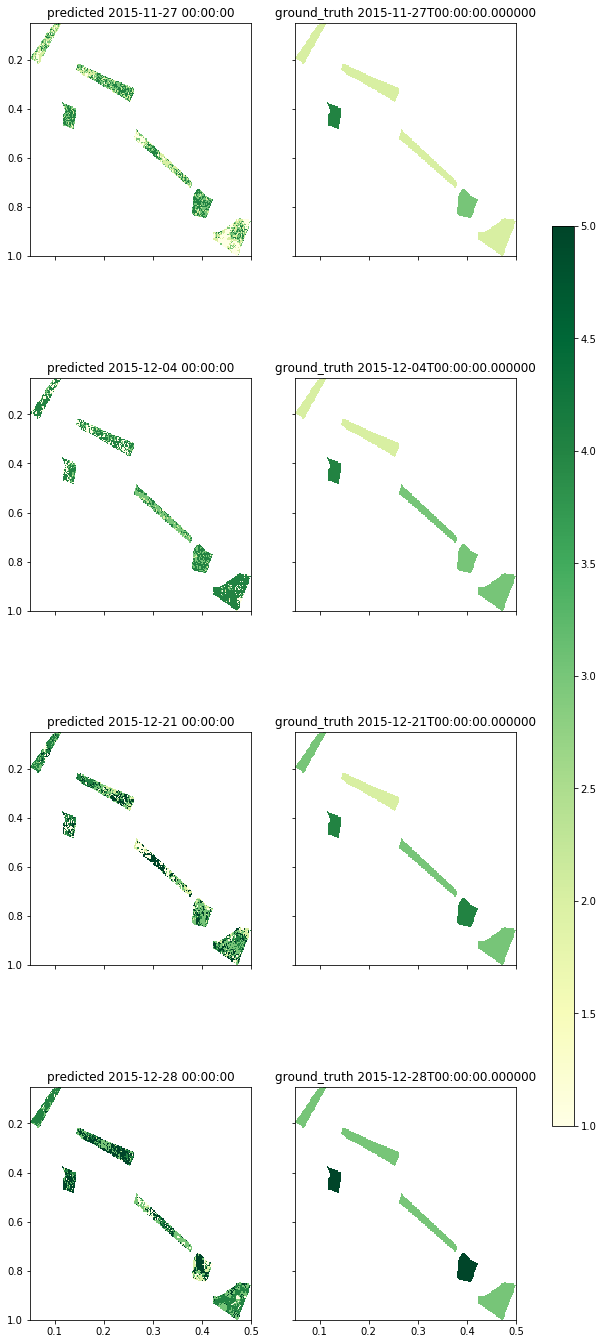

In [217]:
import matplotlib.pyplot as plt
from datetime import datetime#as dt

data_to_plot = []#[predicted, test]
tags = []#['predicted', 'ground_truth']

for time in xarr.time.values:#[0,1,2,3]:
    predicted = xarr.sel(time=time)['predict']
    test = xarr.sel(time=time)['test']
    data_to_plot += [predicted, test]
    tags += ['predicted '+str(time.astype(datetime)), 'ground_truth '+str(time)]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 25), sharex=True, sharey=True)
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(data_to_plot[idx], cmap='YlGn',
     vmin=1, vmax=5, extent=[0.05,0.5,1,0.05],aspect=0.5)
    ax.set_title(tags[idx])

fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax)

<xarray.DataArray 'predict' (time: 6, x: 205, y: 271)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) int64 1448582400000000 1449187200000000 1450656000000000 ...
  * x        (x) int64 500015 500025 500035 500045 500055 500065 500075 ...
  * y        (y) int64 425095 425105 425115 425125 425135 425145 425155 ...

In [48]:
# Concatenate into one xarray
dimnames = xr.Variable('band', pd.Index(['class', 'predict']))
da = xr.concat([original.where(original>0).drop('class_mask'), predicted], dimnames)

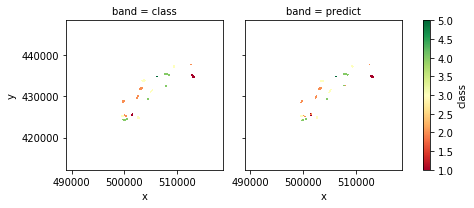

In [50]:
# Plot
da.plot(x='x', y='y', col='band', vmin=1., vmax=5., cmap='RdYlGn')

In [51]:
# Test merging into dataset
merged = xr.merge([original, predicted])
merged

<xarray.Dataset>
Dimensions:     (x: 2979, y: 3631)
Coordinates:
  * y           (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x           (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    class_mask  (x, y) bool dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
Data variables:
    class       (x, y) uint8 dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
    predict     (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...

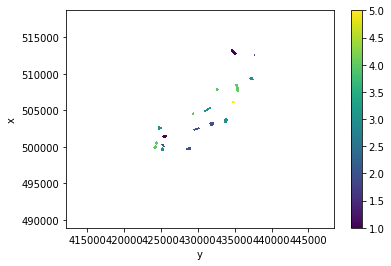

In [52]:
merged['class'].where(merged.class_mask).plot()

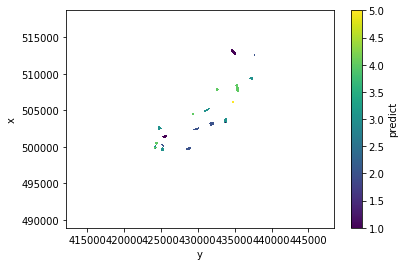

In [53]:
merged['predict'].plot()

In [221]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_a1e4 closed.


## Rest of h2o.ai tutorial

In [169]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [170]:
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)

In [171]:
rf_fit1.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [172]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [175]:
rf_fit2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_fit2


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.4206132597914997
RMSE: 0.6485470374548786
LogLoss: 1.2138039820414677
Mean Per-Class Error: 0.5250613497511829
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
3213.0,374.0,905.0,1055.0,683.0,0.4842697,"3,017 / 6,230"
340.0,1190.0,1230.0,1165.0,230.0,0.7135981,"2,965 / 4,155"
500.0,666.0,4718.0,2358.0,783.0,0.4772299,"4,307 / 9,025"
409.0,498.0,1708.0,4458.0,726.0,0.4283883,"3,341 / 7,799"
795.0,119.0,818.0,767.0,2290.0,0.5218208,"2,499 / 4,789"
5257.0,2847.0,9379.0,9803.0,4712.0,0.5040628,"16,129 / 31,998"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.4959373
2,0.7532659
3,0.9112132
4,0.9831240
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2018-06-18 15:38:56,0.047 sec,0.0,nan,nan,nan
,2018-06-18 15:38:56,0.337 sec,1.0,0.7303790,12.2817779,0.5919030
,2018-06-18 15:38:56,0.543 sec,2.0,0.7203099,10.7833210,0.5901275
,2018-06-18 15:38:56,0.751 sec,3.0,0.7095381,9.5448896,0.5829394
,2018-06-18 15:38:57,0.914 sec,4.0,0.7001012,8.4149456,0.5747498
---,---,---,---,---,---,---
,2018-06-18 15:39:00,3.960 sec,20.0,0.6555561,2.1665261,0.5224865
,2018-06-18 15:39:04,8.106 sec,42.0,0.6502603,1.4000393,0.5078755
,2018-06-18 15:39:08,12.139 sec,64.0,0.6493819,1.2696775,0.5062191
,2018-06-18 15:39:12,16.225 sec,86.0,0.6487907,1.2245171,0.5043753



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
VV_c,229833.0312500,1.0,0.2235553
VV,196951.2031250,0.8569317,0.1915716
VV_GLCMVariance,88588.0937500,0.3854454,0.0861684
VV_GLCMMean,87577.4687500,0.3810482,0.0851854
VV_GLCMCorrelation,77738.0,0.3382368,0.0756147
VV_Homogeneity,67700.2265625,0.2945626,0.0658511
VV_Entropy,60788.5937500,0.2644902,0.0591282
VV_Contrast,57747.9335938,0.2512604,0.0561706
VV_Dissimilarity,56038.2187500,0.2438214,0.0545076
VV_Energy,53866.6523438,0.2343730,0.0523953


In [173]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

TypeError: must be str, not type

In [30]:
print rf_perf1.auc()
print rf_perf2.auc()

0.663462768485
0.669287987873


In [174]:
rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
rf_fit3.train(x=x, y=y, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
print rf_fit3.auc(xval=True)

0.663606041745


In [33]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [34]:
# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [37]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

In [38]:
# Retreive test set AUC
print gbm_perf1.auc()
print gbm_perf2.auc()
print gbm_perf3.auc()

0.683883128672
0.684086466361
0.684443511563


In [39]:
gbm_fit2.scoring_history()

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-04-25 08:45:40,0.028 sec,0.0,0.3856346,0.4740298,0.5,1.0,0.8182546
,2018-04-25 08:45:40,0.128 sec,1.0,0.3837005,0.4691294,0.6577912,2.6832997,0.4006858
,2018-04-25 08:45:40,0.174 sec,2.0,0.3820620,0.4651166,0.6658294,2.7939915,0.3332492
,2018-04-25 08:45:40,0.221 sec,3.0,0.3806936,0.4618385,0.6685103,2.9710023,0.3447454
,2018-04-25 08:45:40,0.276 sec,4.0,0.3795380,0.4591170,0.6701132,2.9754401,0.3318046
---,---,---,---,---,---,---,---,---
,2018-04-25 08:45:43,3.795 sec,43.0,0.3677312,0.4317210,0.7124068,3.6410228,0.2975859
,2018-04-25 08:45:43,3.888 sec,44.0,0.3676187,0.4314625,0.7129225,3.6553764,0.3021722
,2018-04-25 08:45:44,3.989 sec,45.0,0.3674805,0.4311606,0.7134660,3.6649454,0.3023984
,2018-04-25 08:45:48,7.995 sec,226.0,0.3612902,0.4176954,0.7402357,4.2582264,0.2599471


In [40]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [41]:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [42]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [43]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [44]:
dl_perf1 = dl_fit1.model_performance(test)
dl_perf2 = dl_fit2.model_performance(test)
dl_perf3 = dl_fit3.model_performance(test)

In [45]:
# Retreive test set AUC
print dl_perf1.auc()
print dl_perf2.auc()
print dl_perf3.auc()

0.686254936726
0.681516110354
0.681802966019


In [47]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit1.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [48]:
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)
nb_fit2.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [49]:
nb_perf1 = nb_fit1.model_performance(test)
nb_perf2 = nb_fit2.model_performance(test)

In [50]:
# Retreive test set AUC
print nb_perf1.auc()
print nb_perf2.auc()

0.651337099516
0.651391851824
